In previous models, the confidence value, which should ideally be between 0 and 1, has trouble staying within those bounds. 
The reason is because the in the current model architecture, the 5 outputs must use the same linear activation function.
There are two solutions. I can either force all 5 outputs to use a sigmoid function which will force it between 0 and 1.
To do this, the bounding box values will need to be converted to values between 0 and 1 before training. Another method,
would be to apply a sigmoid activation function to only the confidence value while the activations for the bounding boxes
remain linear. I will apply the second method in this model.

In [12]:
%load_ext autoreload
%autoreload 2
from misc import project_utils_multi

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(1)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device. Error.')
    pass

from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from random import randint
import numpy as np

RANDOM_SEED = 0
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.0001
ES_PATIENCE = 10
ES_RESTORE_WEIGHTS = True
PLAY_VIDEOS = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_train = project_utils_multi.load_image_dataframes('./data/train/', 'annotations.json')
display(df_train)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,152.0,140.0,397.0,346.0
1,00002.jpg,1.0,144.0,140.0,403.0,345.0
2,00003.jpg,1.0,142.0,138.0,402.0,346.0
3,00004.jpg,1.0,144.0,140.0,405.0,344.0
4,00005.jpg,1.0,141.0,140.0,407.0,344.0
...,...,...,...,...,...,...
12994,12995.jpg,1.0,416.0,326.0,720.0,688.0
12995,12996.jpg,1.0,326.0,338.0,643.0,589.0
12996,12997.jpg,1.0,278.0,302.0,633.0,582.0
12997,12998.jpg,1.0,366.0,383.0,690.0,654.0


In [3]:
df_test = project_utils_multi.load_image_dataframes('./data/test/', 'annotations.json')
display(df_test)

,id,confidence,y1,x1,y2,x2
0,00001.jpg,1.0,220.0,252.0,411.0,437.0
1,00002.jpg,1.0,217.0,241.0,402.0,432.0
2,00003.jpg,1.0,229.0,252.0,416.0,443.0
3,00004.jpg,1.0,243.0,317.0,425.0,487.0
4,00005.jpg,1.0,274.0,332.0,457.0,510.0
...,...,...,...,...,...,...
107,00108.jpg,0.0,0.0,0.0,0.0,0.0
108,00109.jpg,0.0,0.0,0.0,0.0,0.0
109,00110.jpg,0.0,0.0,0.0,0.0,0.0
110,00111.jpg,0.0,0.0,0.0,0.0,0.0


In [4]:
train_datagen, validation_datagen = project_utils_multi.create_data_generators(df_train, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/train/', test_split=0.2, seed=RANDOM_SEED)
test_datagen = project_utils_multi.create_data_generators(df_test, ['confidence', 'y1', 'x1', 'y2', 'x2'], directory='./data/test/', seed=RANDOM_SEED)
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, num_to_iter=100))
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, num_to_iter=50))
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, num_to_iter=25))

Epoch 1/100
324/324 [==============================] - 87s 237ms/step - loss: 90618.1862 - confidence_output_loss: 0.0426 - bounding_output_loss: 90618.1458 - confidence_output_binary_accuracy: 0.9581 - confidence_output_auc: 0.5080 - bounding_output_iou_metric_multi: 0.0753 - val_loss: 27225.8672 - val_confidence_output_loss: 0.0177 - val_bounding_output_loss: 27225.8496 - val_confidence_output_binary_accuracy: 0.9823 - val_confidence_output_auc: 0.5000 - val_bounding_output_iou_metric_multi: 0.2175
Epoch 2/100
324/324 [==============================] - 76s 235ms/step - loss: 26301.0315 - confidence_output_loss: 0.0246 - bounding_output_loss: 26301.0094 - confidence_output_binary_accuracy: 0.9754 - confidence_output_auc: 0.4985 - bounding_output_iou_metric_multi: 0.2395 - val_loss: 19218.9375 - val_confidence_output_loss: 0.0177 - val_bounding_output_loss: 19218.9180 - val_confidence_output_binary_accuracy: 0.9823 - val_confidence_output_auc: 0.5000 - val_bounding_output_iou_metric_mu

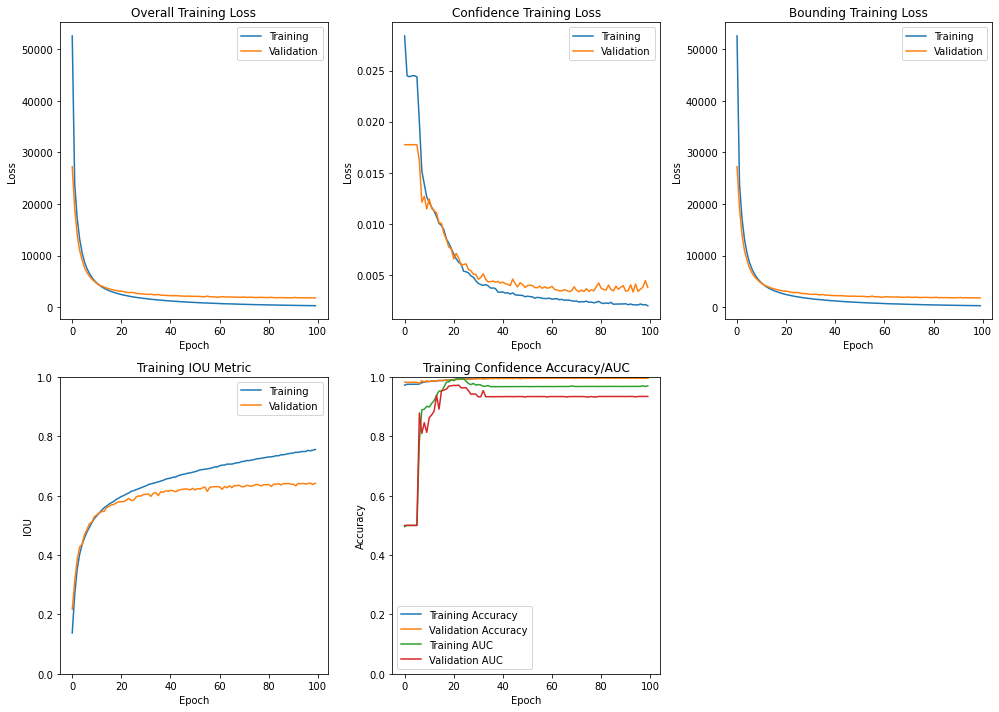

3/3 [==============================] - 1s 181ms/step - loss: 4348.3022 - confidence_output_loss: 0.0937 - bounding_output_loss: 4348.2085 - confidence_output_binary_accuracy: 0.9062 - confidence_output_auc: 0.5000 - bounding_output_iou_metric_multi: 0.4652
Training Loss: 277.7966613769531
Training IOU: 0.0019414263078942895
Validation Loss: 1800.7613525390625
Validation IOU: 0.0037691467441618443
Testing Loss: 4348.30224609375
Testing IOU: 0.09374994039535522


In [5]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

hidden = keras.layers.Dense(1024, activation='relu')(flatten)

confHead = keras.layers.Dense(1, activation='sigmoid', name='confidence_output')(hidden)
bbHead = keras.layers.Dense(4, activation='linear', name='bounding_output')(hidden)

model = keras.models.Model(inputs=vgg.input, outputs=[confHead, bbHead])
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='mse', optimizer=opt, metrics=[[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()], [project_utils_multi.iou_metric_multi]])#, run_eagerly=True)

es = EarlyStopping(monitor='val_bounding_output_iou_metric_multi', mode='max', verbose=1, patience=ES_PATIENCE, restore_best_weights=ES_RESTORE_WEIGHTS)
history = model.fit(train_datagen, 
                    steps_per_epoch=train_datagen.get_length() // BATCH_SIZE,
                    validation_data=validation_datagen, 
                    validation_steps = validation_datagen.get_length() // BATCH_SIZE,
                    epochs=EPOCHS, 
                    callbacks=[es])

project_utils_multi.plot_history(history)

train_results = model.evaluate(train_datagen)
validation_results = model.evaluate(validation_datagen)
test_results  = model.evaluate(test_datagen)
print('Training Loss: {}\nTraining IOU: {}'.format(train_results[0], train_results[1]))
print('Validation Loss: {}\nValidation IOU: {}'.format(validation_results[0], validation_results[1]))
print('Testing Loss: {}\nTesting IOU: {}'.format(test_results[0], test_results[1]))

pos_neg_counts = project_utils.get_negative_positive_count('../data/train/', 'annotations.json')
project_utils_multi.write_results('./history.txt', model, history, train_datagen.get_length(), validation_datagen.get_length(), pos_neg_counts)

In [6]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(train_datagen, model=model, num_to_iter=100))

In [7]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(validation_datagen, model=model, num_to_iter=50))

In [8]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_sequence_datagen(test_datagen, model=model, num_to_iter=1))

In [9]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_webcam.mp4', model=model))

In [10]:
if PLAY_VIDEOS:
    display(project_utils_multi.play_images_from_video('../../data/original/test_videos/hand_signs_hand_only.mp4', model=model))